In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import statsmodels.api as sm
from sklearn.linear_model import QuantileRegressor, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_pinball_loss
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor

# from xgboost import XGBRegressor, plot_tree
# import xgboost as xgb
# import lightgbm as lgb

# = = = = = =
# own stuff
# = = = = = =
os.chdir("C:/2023_11-PTSFC")
import data_prepro as data_prepro
# from data_prepro import get_energy_data_today, create_dummy_df, create_features_df

In [2]:
# from importlib import reload
# reload(data_prepro)

### Data Prep

In [3]:
# ITERATIVE FCAST ... 1/2 day each time ... 6 times = 3 days ahead

# = = = = = = = = = = = = = 
# generate prediction timestamps based on t0 = following thursday 00:00 dynamically

# get current date and set time to 00:00
t_now = pd.Timestamp.now(tz='CET').replace(hour=0, minute=0, second=0, microsecond=0)
# t_now = pd.Timestamp(year=2023, month=1, day=18, hour=0, minute=0, second=0, microsecond=0, tz='CET')

# get days left till thursday
days_left = 3 - t_now.dayofweek
# get thursday and wednesday
t_thursday = t_now + pd.Timedelta(days=days_left)
t_wednesday = t_thursday - pd.Timedelta(days=1)
print(f"wed = {t_wednesday}")
print(f"thu = {t_thursday}")

# = = = = = = = = = = = = = 
# get data
df_energy = data_prepro.get_energy_data_today(to_date=t_wednesday.strftime('%Y%m%d'))
df_energy.info()
df_energy.tail(5)

wed = 2024-01-10 00:00:00+01:00
thu = 2024-01-11 00:00:00+01:00
C:\2023_11-PTSFC
to_date is later than 2023-11-01, using historic and recent data !
0 NA in df
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79123 entries, 2014-12-31 23:00:00+00:00 to 2024-01-10 17:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  79123 non-null  datetime64[ns, CET]
 1   gesamt         79123 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB


,timestamp_CET,gesamt
timestamp_UTC,,
2024-01-10 13:00:00+00:00,2024-01-10 14:00:00+01:00,68213.00
2024-01-10 14:00:00+00:00,2024-01-10 15:00:00+01:00,67576.00
2024-01-10 15:00:00+00:00,2024-01-10 16:00:00+01:00,67934.50
2024-01-10 16:00:00+00:00,2024-01-10 17:00:00+01:00,70504.25
2024-01-10 17:00:00+00:00,2024-01-10 18:00:00+01:00,52604.50


In [4]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# take smaller dataset
start   = '2018-01-01'
# end     = '2024-01-01'
end     = df_energy['timestamp_CET'].max()
df_energy_small = df_energy.loc[(df_energy['timestamp_CET'] > start) &
                                (df_energy['timestamp_CET'] <= end)]
print(df_energy_small.info())

df_energy_dummy = data_prepro.create_dummy_df(df_energy_small, hour_method='seasonal', holiday_method='separate')
df_energy_fturs = data_prepro.create_features_df(df_energy_small, holiday_method='separate', lags=[24, 7*24])

X_train_fturs = df_energy_fturs.drop(['gesamt', 'timestamp_CET'], axis=1)
y_train_fturs = df_energy_fturs['gesamt']

X_train_dummy = df_energy_dummy.drop(['gesamt', 'timestamp_CET'], axis=1)
y_train_dummy = df_energy_dummy['gesamt']

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52818 entries, 2018-01-01 00:00:00+00:00 to 2024-01-10 17:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  52818 non-null  datetime64[ns, CET]
 1   gesamt         52818 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.2 MB
None


### Model Train

In [5]:
os.environ["LOKY_MAX_CPU_COUNT"] = "1"  # Replace "4" with the desired number of cores
quantiles_arr = [0.025, 0.25, 0.5, 0.75, 0.975]

In [6]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# train quantile models ... regression and gradient boosting

# - - - - - - - - - -
# quantile regression with dummies

# !!! IMPORTANT !!!
# check best params ... alpha = ??? 

print('- '*15)  
print(f'> start training quantile regression models ...')
all_models_quant_reg = {}
for alpha in quantiles_arr:

    print(f'>> alpha = {alpha:.3f} ...')
    quantile_regressor = QuantileRegressor(quantile=alpha, alpha=0, solver='highs')
    all_models_quant_reg[f"q {alpha:.3f}"] = quantile_regressor.fit(X_train_dummy, y_train_dummy)

    # print(quantile_regressor.intercept_)
    # df_coef_w_names = pd.DataFrame(quantile_regressor.coef_, index=quantile_regressor.feature_names_in_)
    # print(df_coef_w_names.to_string())

- - - - - - - - - - - - - - - 
> start training quantile regression models ...
>> alpha = 0.025 ...
>> alpha = 0.250 ...
>> alpha = 0.500 ...
>> alpha = 0.750 ...
>> alpha = 0.975 ...


In [7]:
# - - - - - - - - - -
# gradient boosting with features

# !!! IMPORTANT !!! 
# grid search for best params
# for each quantile ???

# common_params = dict(
#     learning_rate=0.3,
#     max_depth=7,
#     min_samples_leaf=5,
#     n_estimators=300, 
#     subsample=0.9
# )
    
quantile_params = {0.025: {'learning_rate': 0.4, 'max_depth': 10, 'min_samples_leaf': 7, 'n_estimators': 400, 'subsample': 0.9}, 
                   0.250: {'learning_rate': 0.3, 'max_depth': 10, 'min_samples_leaf': 6, 'n_estimators': 250, 'subsample': 0.7},
                   0.500: {'learning_rate': 0.3, 'max_depth': 5, 'min_samples_leaf': 6, 'n_estimators': 400, 'subsample': 0.8},
                   0.750: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 7, 'n_estimators': 250, 'subsample': 0.7},
                   0.975: {'learning_rate': 0.4, 'max_depth': 10, 'min_samples_leaf': 6, 'n_estimators': 400, 'subsample': 0.7}}

# quantile_params = {0.025: {'learning_rate': 0.4, 'max_depth': 10, 'min_samples_leaf': 7}, 
#                    0.250: {'learning_rate': 0.3, 'max_depth': 10, 'min_samples_leaf': 6},
#                    0.500: {'learning_rate': 0.3, 'max_depth': 5, 'min_samples_leaf': 6},
#                    0.750: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 7},
#                    0.975: {'learning_rate': 0.4, 'max_depth': 10, 'min_samples_leaf': 6}}

print('- '*15)  
print(f'> start training gradient boosting models ...')
all_models_grad_boost = {}
for alpha in quantiles_arr:

    print(f'>> alpha = {alpha:.3f} ...')

    params = quantile_params[alpha]
    # pprint(params)

    # Use the QuantileRegressor for faster training on small to medium datasets n < 10_000
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **params)

    # Use the HistGradientBoostingRegressor for faster training on large datasets n > 10_000
    # gbr = HistGradientBoostingRegressor(loss='quantile', quantile=alpha, **params)

    all_models_grad_boost[f"q {alpha:.3f}"] = gbr.fit(X_train_fturs, y_train_fturs)


- - - - - - - - - - - - - - - 
> start training gradient boosting models ...
>> alpha = 0.025 ...
>> alpha = 0.250 ...
>> alpha = 0.500 ...
>> alpha = 0.750 ...
>> alpha = 0.975 ...


### Forecast from Thursday

In [8]:
# from importlib import reload
# reload(data_prepro)

2024-01-03 17:00:00+00:00 2024-01-10 17:00:00+00:00
- - - - - - - - - - - - - - - 
> to be forecasted
DatetimeIndex(['2024-01-10 18:00:00+00:00', '2024-01-10 19:00:00+00:00',
               '2024-01-10 20:00:00+00:00', '2024-01-10 21:00:00+00:00',
               '2024-01-10 22:00:00+00:00', '2024-01-10 23:00:00+00:00',
               '2024-01-11 00:00:00+00:00', '2024-01-11 01:00:00+00:00',
               '2024-01-11 02:00:00+00:00', '2024-01-11 03:00:00+00:00',
               '2024-01-11 04:00:00+00:00', '2024-01-11 05:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='H')
- - - - - - - - - - - - - - - 
> start prediction ...


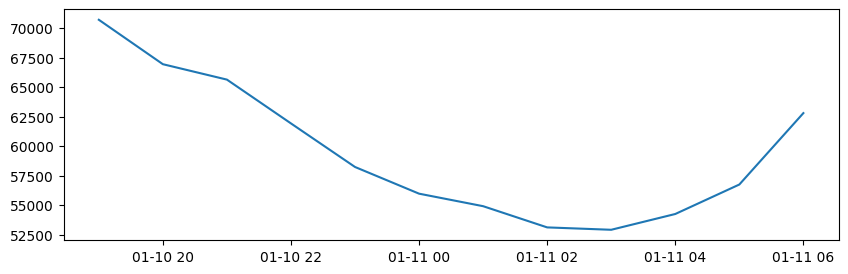

new end timestamp: 2024-01-11 05:00:00+00:00
- - - - - - - - - - - - - - - 
> to be forecasted
DatetimeIndex(['2024-01-11 06:00:00+00:00', '2024-01-11 07:00:00+00:00',
               '2024-01-11 08:00:00+00:00', '2024-01-11 09:00:00+00:00',
               '2024-01-11 10:00:00+00:00', '2024-01-11 11:00:00+00:00',
               '2024-01-11 12:00:00+00:00', '2024-01-11 13:00:00+00:00',
               '2024-01-11 14:00:00+00:00', '2024-01-11 15:00:00+00:00',
               '2024-01-11 16:00:00+00:00', '2024-01-11 17:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='H')
- - - - - - - - - - - - - - - 
> start prediction ...


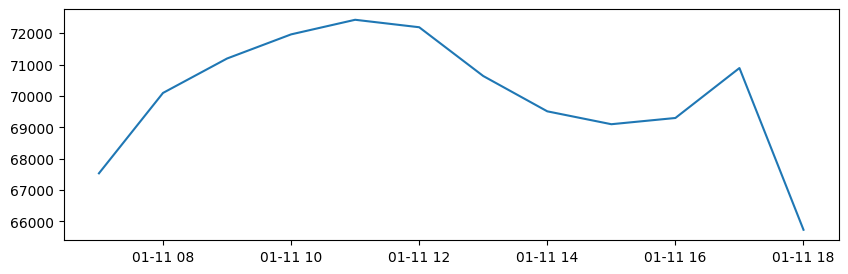

new end timestamp: 2024-01-11 17:00:00+00:00
- - - - - - - - - - - - - - - 
> to be forecasted
DatetimeIndex(['2024-01-11 18:00:00+00:00', '2024-01-11 19:00:00+00:00',
               '2024-01-11 20:00:00+00:00', '2024-01-11 21:00:00+00:00',
               '2024-01-11 22:00:00+00:00', '2024-01-11 23:00:00+00:00',
               '2024-01-12 00:00:00+00:00', '2024-01-12 01:00:00+00:00',
               '2024-01-12 02:00:00+00:00', '2024-01-12 03:00:00+00:00',
               '2024-01-12 04:00:00+00:00', '2024-01-12 05:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='H')
- - - - - - - - - - - - - - - 
> start prediction ...


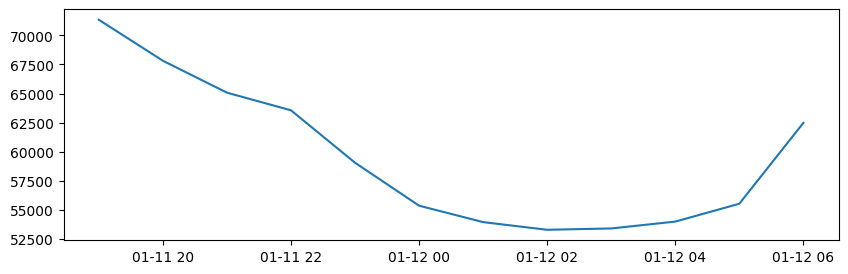

new end timestamp: 2024-01-12 05:00:00+00:00
- - - - - - - - - - - - - - - 
> to be forecasted
DatetimeIndex(['2024-01-12 06:00:00+00:00', '2024-01-12 07:00:00+00:00',
               '2024-01-12 08:00:00+00:00', '2024-01-12 09:00:00+00:00',
               '2024-01-12 10:00:00+00:00', '2024-01-12 11:00:00+00:00',
               '2024-01-12 12:00:00+00:00', '2024-01-12 13:00:00+00:00',
               '2024-01-12 14:00:00+00:00', '2024-01-12 15:00:00+00:00',
               '2024-01-12 16:00:00+00:00', '2024-01-12 17:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='H')
- - - - - - - - - - - - - - - 
> start prediction ...


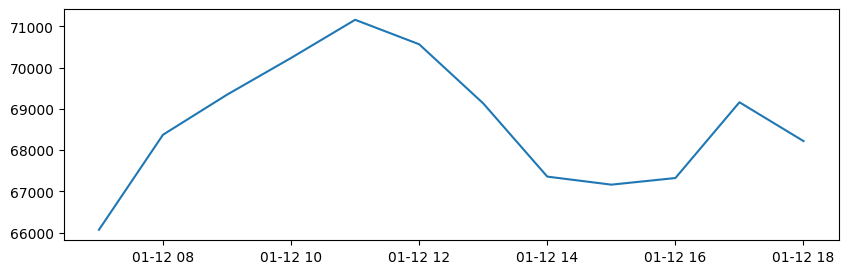

new end timestamp: 2024-01-12 17:00:00+00:00
- - - - - - - - - - - - - - - 
> to be forecasted
DatetimeIndex(['2024-01-12 18:00:00+00:00', '2024-01-12 19:00:00+00:00',
               '2024-01-12 20:00:00+00:00', '2024-01-12 21:00:00+00:00',
               '2024-01-12 22:00:00+00:00', '2024-01-12 23:00:00+00:00',
               '2024-01-13 00:00:00+00:00', '2024-01-13 01:00:00+00:00',
               '2024-01-13 02:00:00+00:00', '2024-01-13 03:00:00+00:00',
               '2024-01-13 04:00:00+00:00', '2024-01-13 05:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='H')
- - - - - - - - - - - - - - - 
> start prediction ...


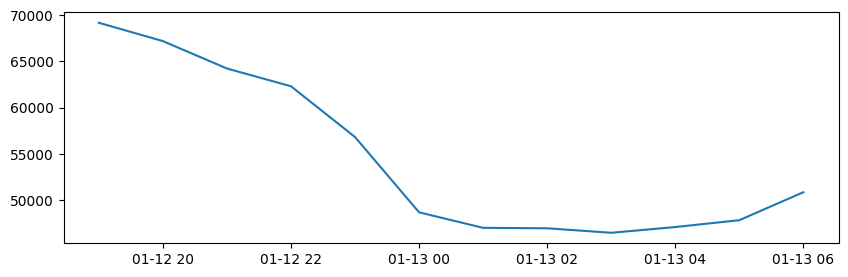

new end timestamp: 2024-01-13 05:00:00+00:00
- - - - - - - - - - - - - - - 
> to be forecasted
DatetimeIndex(['2024-01-13 06:00:00+00:00', '2024-01-13 07:00:00+00:00',
               '2024-01-13 08:00:00+00:00', '2024-01-13 09:00:00+00:00',
               '2024-01-13 10:00:00+00:00', '2024-01-13 11:00:00+00:00',
               '2024-01-13 12:00:00+00:00', '2024-01-13 13:00:00+00:00',
               '2024-01-13 14:00:00+00:00', '2024-01-13 15:00:00+00:00',
               '2024-01-13 16:00:00+00:00', '2024-01-13 17:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='H')
- - - - - - - - - - - - - - - 
> start prediction ...


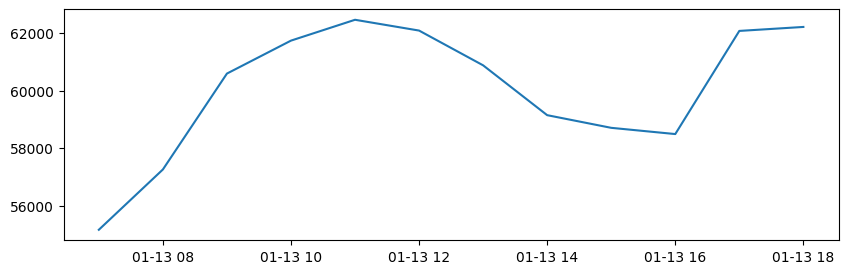

new end timestamp: 2024-01-13 17:00:00+00:00
- - - - - - - - - - - - - - - 
> to be forecasted
DatetimeIndex(['2024-01-13 18:00:00+00:00', '2024-01-13 19:00:00+00:00',
               '2024-01-13 20:00:00+00:00', '2024-01-13 21:00:00+00:00',
               '2024-01-13 22:00:00+00:00', '2024-01-13 23:00:00+00:00',
               '2024-01-14 00:00:00+00:00', '2024-01-14 01:00:00+00:00',
               '2024-01-14 02:00:00+00:00', '2024-01-14 03:00:00+00:00',
               '2024-01-14 04:00:00+00:00', '2024-01-14 05:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='H')
- - - - - - - - - - - - - - - 
> start prediction ...


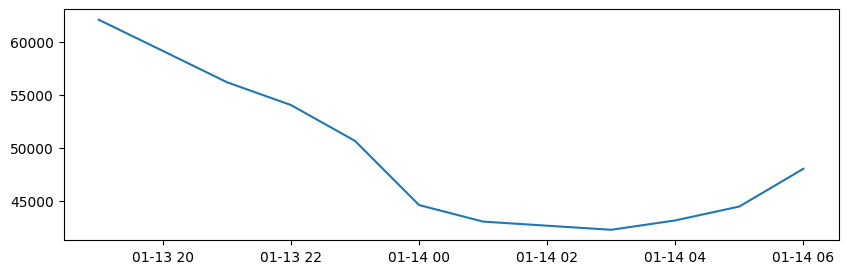

new end timestamp: 2024-01-14 05:00:00+00:00
- - - - - - - - - - - - - - - 
> to be forecasted
DatetimeIndex(['2024-01-14 06:00:00+00:00', '2024-01-14 07:00:00+00:00',
               '2024-01-14 08:00:00+00:00', '2024-01-14 09:00:00+00:00',
               '2024-01-14 10:00:00+00:00', '2024-01-14 11:00:00+00:00',
               '2024-01-14 12:00:00+00:00', '2024-01-14 13:00:00+00:00',
               '2024-01-14 14:00:00+00:00', '2024-01-14 15:00:00+00:00',
               '2024-01-14 16:00:00+00:00', '2024-01-14 17:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='H')
- - - - - - - - - - - - - - - 
> start prediction ...


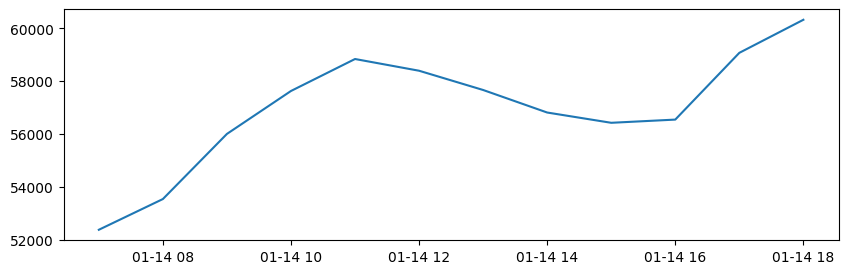

= = = = = = = = = = = = = = = 
= = = = = = = = = = = = = = = 
all iterative fcasts done ...


,q 0.025,q 0.250,q 0.500,q 0.750,q 0.975
2024-01-10 18:00:00+00:00,62809.953096,68047.495419,70718.380826,72395.020867,73513.056954
2024-01-10 19:00:00+00:00,59203.419871,65726.326655,66952.104759,68474.313010,69123.922476
2024-01-10 20:00:00+00:00,56399.624798,61874.827750,65645.085362,65512.679667,68418.377955
2024-01-10 21:00:00+00:00,53807.190169,59736.606267,61930.237304,63547.742088,65398.865303
2024-01-10 22:00:00+00:00,50546.503763,56432.801867,58237.332548,59974.282901,63746.997778
...,...,...,...,...,...
2024-01-14 13:00:00+00:00,49521.100960,53602.417860,56818.818197,59323.944667,62572.038743
2024-01-14 14:00:00+00:00,48901.395564,52797.749442,56430.596071,58789.810827,62267.757998
2024-01-14 15:00:00+00:00,49039.493443,53298.468252,56551.584847,58891.005150,62483.196395
2024-01-14 16:00:00+00:00,51770.625512,56963.765099,59074.543026,61336.598361,64673.979265


In [9]:
# take smaller dataset
end     = df_energy.index.max()
start   = df_energy.index.max()-pd.Timedelta(days=7)
print(start, end)

# this dataframe has values of past 7 days = last week
# because in the first step we predict the next 12 hours
# and we need the lagged values of last week for grad boost features
df_energy_small = df_energy.loc[(df_energy.index > start) &
                                (df_energy.index <= end)]

df_fcast_all = pd.DataFrame()

for fcast_iter in range(8):

    if fcast_iter > 0:
        df_energy_small = pd.concat((df_energy_small, df_ens_fcast_loop))
        end = df_energy_small.index.max()
        print(f"new end timestamp: {end}")

    # add fcast index for next 12 hours
    fcast_timestamp_UTC = pd.date_range(start=end, periods=13, freq='H')[1:]
    fcast_timestamp_CET = fcast_timestamp_UTC.tz_convert('CET')

    print('- '*15) 
    print(f"> to be forecasted")
    print(fcast_timestamp_UTC)

    # create df with timestamps of next 12 hours
    df_temp = pd.DataFrame(index=fcast_timestamp_UTC)
    df_temp['timestamp_CET'] = fcast_timestamp_CET

    # add to dataframe as new rows with NaN values in gesamt column
    df_fcast = pd.concat((df_energy_small, df_temp))

    # use data from last week for features
    # take only the last 12 rows
    df_fcast_fturs = data_prepro.create_features_df(df_fcast, holiday_method='separate', lags=[24, 7*24]).tail(12)
    df_fcast_dummy = data_prepro.create_dummy_df(df_fcast, hour_method='seasonal', holiday_method='separate').tail(12)

    # print(df_fcast_dummy.index)
    # print(df_fcast_fturs.index)

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
    # fcast

    print('- '*15)    
    print(f'> start prediction ...')

    # save fcast in df with columns = quantiles
    df_quant_reg_fcast = pd.DataFrame(index=df_fcast_dummy.index)
    df_grad_boost_fcast = pd.DataFrame(index=df_fcast_fturs.index)

    # Prediction for Quantile Regression
    for name, quant_reg_model in sorted(all_models_quant_reg.items()):
        pred = quant_reg_model.predict(df_fcast_dummy.drop(['gesamt', 'timestamp_CET'], axis=1))
        df_quant_reg_fcast[name] = pred

    # Prediction for Gradient Boosting
    for name, grad_boost_model in sorted(all_models_grad_boost.items()):
        pred = grad_boost_model.predict(df_fcast_fturs.drop(['gesamt', 'timestamp_CET'], axis=1))
        df_grad_boost_fcast[name] = pred

    # take ensemble of q 0.500 of both models
    ens_fcast = (df_quant_reg_fcast['q 0.500'].values + df_grad_boost_fcast['q 0.500'].values) / 2
    df_ens_fcast_loop = pd.DataFrame(index=df_quant_reg_fcast.index)
    df_ens_fcast_loop['timestamp_CET'] = df_ens_fcast_loop.index.tz_convert('CET')
    df_ens_fcast_loop['gesamt'] = ens_fcast
    df_ens_fcast_loop

    plt.figure(figsize=(10,3))
    plt.plot(df_ens_fcast_loop['timestamp_CET'], ens_fcast)
    plt.show()

    # save fcast to df
    df_ens_fcast_out = (df_quant_reg_fcast * 0.5 + df_grad_boost_fcast * 0.5)
    df_ens_fcast_out = df_ens_fcast_out.groupby(df_ens_fcast_out.index).mean()
    df_fcast_all = pd.concat((df_fcast_all, df_ens_fcast_out))

print('= '*15)
print('= '*15)
print(f"all iterative fcasts done ...")
display(df_fcast_all)

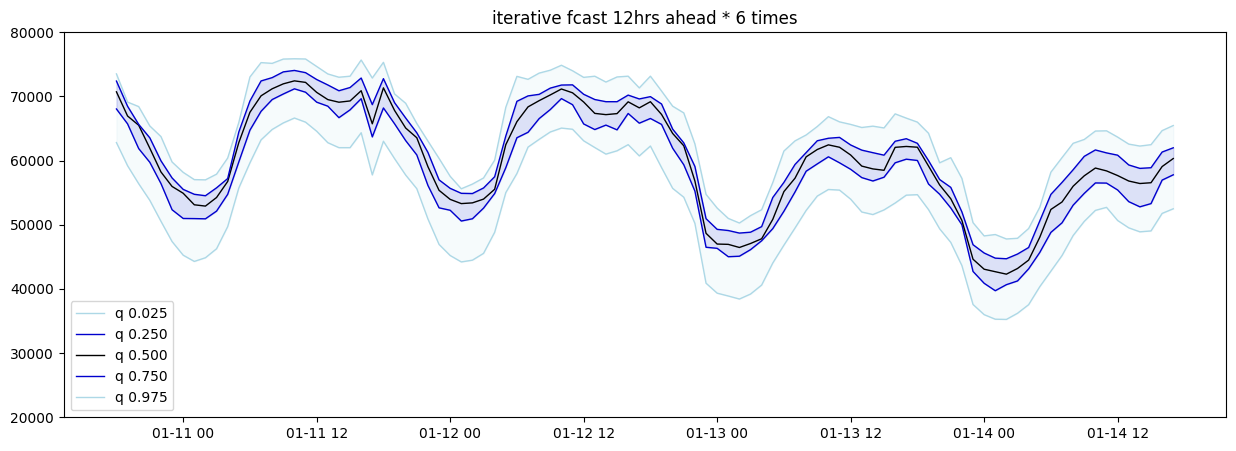

In [10]:
df_fcast_all_fixed = data_prepro.fix_quantile_crossing(df_fcast_all)

plt.figure(figsize=(15, 5))
plt.title(f'iterative fcast 12hrs ahead * 6 times')

df = df_fcast_all_fixed.copy()

for quantile in df.columns:

    y_pred = df[quantile]
    quantile_float = float(quantile[2:])

    # Save predicted values based on quantile
    if '0.025' in quantile:
        y_pred_025 = y_pred
        col = 'lightblue'
    elif '0.25' in quantile:
        y_pred_25 = y_pred
        col = 'mediumblue'
    elif '0.5' in quantile:
        y_pred_50 = y_pred
        col = 'black'
    elif '0.75' in quantile:
        y_pred_75 = y_pred
        col = 'mediumblue'
    elif '0.975' in quantile:
        y_pred_975 = y_pred
        col = 'lightblue'
    
    # Plot the prediction line
    plt.plot(df.index, y_pred, label=f'{quantile}', lw=1, alpha=1, color=col)

plt.fill_between(df.index, y_pred_025, y_pred_975, color='lightblue', alpha=0.1)
plt.fill_between(df.index, y_pred_25, y_pred_75, color='mediumblue', alpha=0.1)

plt.ylim(20_000, 80_000)
plt.legend()
plt.show()

### Save Fcast to csv

In [12]:
# - - - - - - - - - - - - - 
# current index is utc add cet col
df_fcast_all_fixed['timestamp_CET'] = df_fcast_all_fixed.index.tz_convert('CET')
# reorder cols
df_fcast_all_fixed = df_fcast_all_fixed[['timestamp_CET', 'q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']]
# display(df_fcast_all_fixed)

# - - - - - - - - - - - - - 
# get required submission horizons
fcast_hor = [36, 40, 44, 60, 64, 68] # in hours

# based on fcast horizons generate timestamps from t0
fcast_idx = []
for fcast in fcast_hor:
    fcast_idx.append(t_thursday + pd.Timedelta(hours=fcast))
print(fcast_idx)

# - - - - - - - - - - - - - 
# get fcast values for required submission horizons
df_submission = df_fcast_all_fixed.loc[df_fcast_all_fixed.index.isin(fcast_idx)]
# display(df_submission)

# - - - - - - - - - - - - - 
# turn to array and div by 1000
submission_arr = np.array(df_submission.iloc[:,1:]/1000)

df_sub = pd.DataFrame({
    
    "forecast_date": t_wednesday.strftime("%Y-%m-%d"), 
    "target": "energy",
    "horizon": [str(h) + " hour" for h in fcast_hor],
    "q0.025": submission_arr[:,0],
    "q0.25": submission_arr[:,1],
    "q0.5": submission_arr[:,2],
    "q0.75": submission_arr[:,3],
    "q0.975": submission_arr[:,4]

})

# - - - - - - - - - - - - - 
# if folder with name {current wednesday} does not exists in 2023_11-PTSFC/submissions/... create it
# if folder exists ... save csv to it

fname_time = t_wednesday.strftime('%Y_%m_%d')
path = f"C:/2023_11-PTSFC/submissions/{fname_time}"
if not os.path.exists(path):
    os.makedirs(path)

df_sub.to_csv(f"{path}/{fname_time}_power_fcast.csv", index=False)
display(df_sub)

[Timestamp('2024-01-12 12:00:00+0100', tz='CET'), Timestamp('2024-01-12 16:00:00+0100', tz='CET'), Timestamp('2024-01-12 20:00:00+0100', tz='CET'), Timestamp('2024-01-13 12:00:00+0100', tz='CET'), Timestamp('2024-01-13 16:00:00+0100', tz='CET'), Timestamp('2024-01-13 20:00:00+0100', tz='CET')]


,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-01-10,energy,36 hour,64.886626,68.714618,70.566815,71.805704,74.001419
1,2024-01-10,energy,40 hour,61.527319,64.794079,67.325175,69.182393,73.036034
2,2024-01-10,energy,44 hour,58.918016,65.641857,67.197108,68.824764,70.847355
3,2024-01-10,energy,60 hour,55.404914,59.657298,62.080287,63.618100,66.037723
4,2024-01-10,energy,64 hour,52.316317,57.414284,58.489970,60.848525,65.092144
5,2024-01-10,energy,68 hour,52.364609,56.348559,59.155365,60.002772,64.259275
